# Self Organizing Maps

## Import

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from ipywidgets import interactive, IntSlider, FloatSlider, fixed

In [0]:
!pip install minisom

In [0]:
from minisom import MiniSom

## Loading Drive 

In [245]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


# Definitions

In [0]:
def train_som(data, x, y, input_len, sigma, learning_rate, iterations, verbose):
    som = MiniSom(x=x, y=y,
                  input_len = input_len,
                  sigma = sigma,
                  learning_rate = learning_rate)
    
    som.random_weights_init(data)

    som.train_random(data, iterations, verbose=verbose)

    weights = som.get_weights()

    return som, weights

In [0]:
def som_color(data, som, weights, var_names, *arg):
    assert data.shape[1]>1, 'Not enought variables, need at least 2'

    fig, ax = plt.subplots(nrows=2, ncols=data.shape[1], figsize=(14,10))

    # SOMs
    ax[0,0].set_title('SOMs')
    if data.shape[1]<3: # if data shape == 2, adding a dimension to the imshow
        cube  = np.zeros((som_x,som_y,3))
        for i in range(data.shape[1]):
            cube[:,:,i] = weights[:,:,i]
        ax[0,0].imshow(cube)
    else:
        ax[0,0].imshow(weights)

    # distance map
    ax[0,1].set_title('distance map ; mean = %.2f' % np.mean(som.distance_map()))
    ax1 = ax[0,1].imshow(som.distance_map())


    # activation response
    if arg and data.shape[1]>2:
        ax[0,2].set_title('activation response')
        ax2 = ax[0,2].imshow(som.activation_response(data))
        plt.colorbar(ax2,ax=ax[0,2])
        if data.shape[1]>3:
            for i in range(3,data.shape[1]):
                ax[0,i].axis('off')
    else:
        for i in range(2,data.shape[1]):
            ax[0,i].axis('off') # hide subplot


    # variables plots
    for i in range(data.shape[1]):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
        ax[1,i].imshow(weights[:,:,i])
        ax[1,i].set_axis_off()

    plt.show()

# Colors 

In [0]:
nb=10000

dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,
                        dat2,
                        dat3,
                        )).T

color_names = ['Red', 'Green', 'Blue']

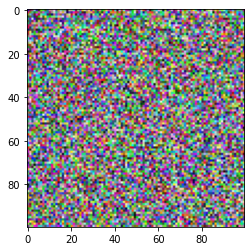

In [79]:
plt.imshow(data_color.reshape(100,100,3));

In [153]:
#som_x, som_y = [50,50] # SOMs shape

som_x = int(np.sqrt(5*np.sqrt(nb)))
som_y = som_x
print("SOMs len side : x = %d " % som_x)
print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, 
                           som_x, som_y, 
                           data_color.shape[1], 
                           sigma=sigma, 
                           learning_rate=learning_rate,
                           iterations = 5000,
                           verbose=True)

SOMs len side : x = 22 
sigma = 4.204816 ; learning rate 1.989742 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.13422217289263025


### Interactive SOMs

In [0]:
def interactive_som(data_color, sigma, learning_rate, iterations):
    som, wts = train_som(data_color, 
                         som_x, som_y, 
                         data_color.shape[1], 
                         sigma=sigma, 
                         learning_rate=learning_rate,
                         iterations = iterations,
                         verbose=False)
    
    som_color(data_color, som, wts, color_names)

    print('quantization error :', som.quantization_error(data_color))
    print('topographic error :', som.topographic_error(data_color))

In [273]:
som_x = int(np.sqrt(5*np.sqrt(nb)))
som_y = som_x

interactive_plot = interactive(interactive_som,
                               data_color = fixed(data_color),
                               sigma=FloatSlider(min=1, max=int(som_x/2.01), step=0.5, value=int(som_x/4)),
                               learning_rate=FloatSlider(min=1, max=5, step=0.5, value=1),
                               iterations=IntSlider(min=1000, max=15000, step=1000, value=5000))
interactive_plot

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=1.0, step=0.5), FloatSlider(va…

### Test hyperparams auto

In [230]:
# finding the 2 parameters at the same time

space = {'sig' : hp.uniform('sig', 0.001, som_x/2.01),
         'learnR' :hp.uniform('learnR', 0.001, 4)}

def som_fn(space):
    sig = space['sig']
    learnR = space['learnR']

    val = MiniSom(x,y,
                  data_color.shape[1],
                  sig,
                  learnR,
                  ).quantization_error(data_color)

    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(
    fn = som_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = trials
    )

sigma = best_params['sig']
learning_rate = best_params['learnR']

print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

100%|██████████| 50/50 [00:03<00:00, 14.18it/s, best loss: 0.23901981627378624]
sigma = 6.664794 ; learning rate 3.806254 



In [240]:
# finding sigma only

learning_rate = 1

best_sig = fmin(
    fn = lambda sig : MiniSom(som_x,som_y,
                              data_color.shape[1],
                              sig,
                              learning_rate
                              ).quantization_error(data_color),
    space = hp.uniform("sig", 2, x/2.01),
    algo = tpe.suggest,
    max_evals=100)

sigma = best_sig["sig"]


# finding learning rate only

best_learnR = fmin(
    fn = lambda learning_rate : MiniSom(x,y,
                                    input_len,
                                    sigma,
                                    learning_rate
                                    ).quantization_error(data_color),
    space = hp.uniform("learnR", 0.5, 5),
    algo = tpe.suggest,
    max_evals=100)

learning_rate = best_learnR["learnR"]

#~~~~~~~~~~~~~~~
print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

100%|██████████| 100/100 [00:06<00:00, 15.15it/s, best loss: 0.23994268436783386]
sigma = 4.727928 ; learning rate 2.678850 



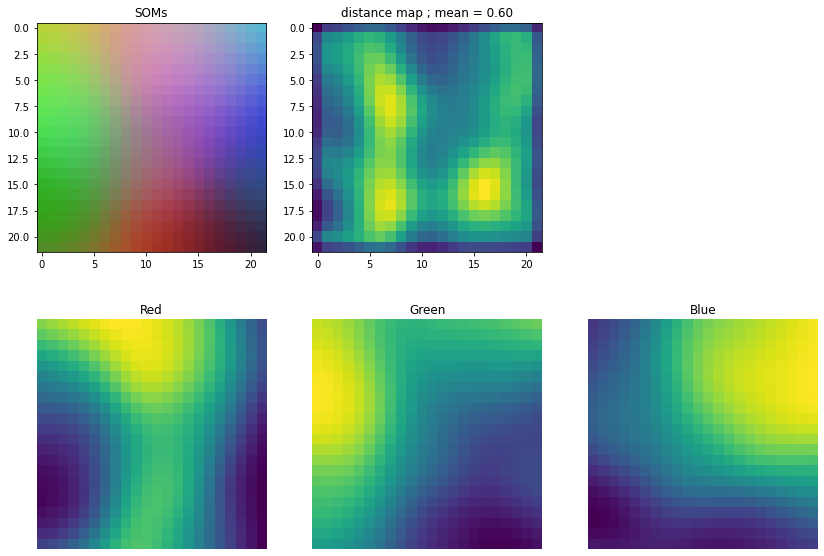

In [74]:
som, wts_color = train_som(x, y, input_len, sigma, learning_rate)

som_color(data_color, wts_color, color_names) # sigma = 5.898, learning_rate = 1.187

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


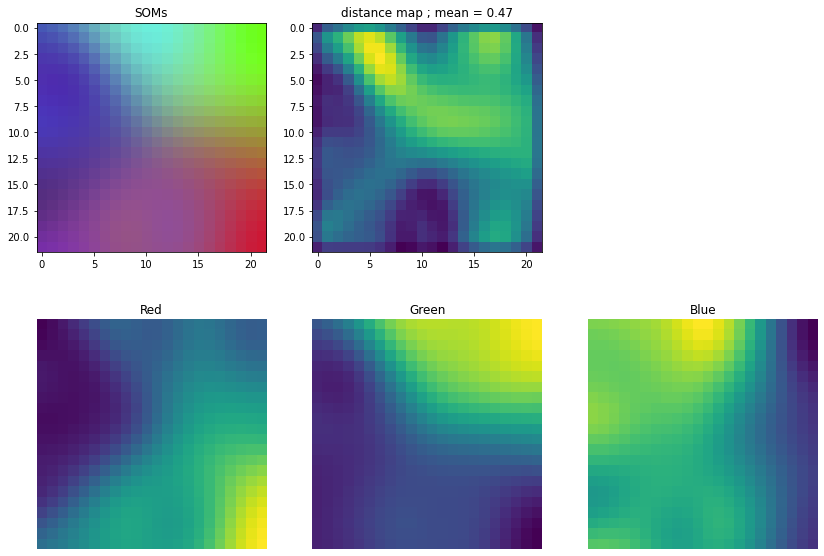

In [62]:
som, wts_color = train_som(x, y, input_len, sigma, learning_rate)

som_color(data_color, wts_color, color_names)# sigma = 9.263, learning_rate = 3.905

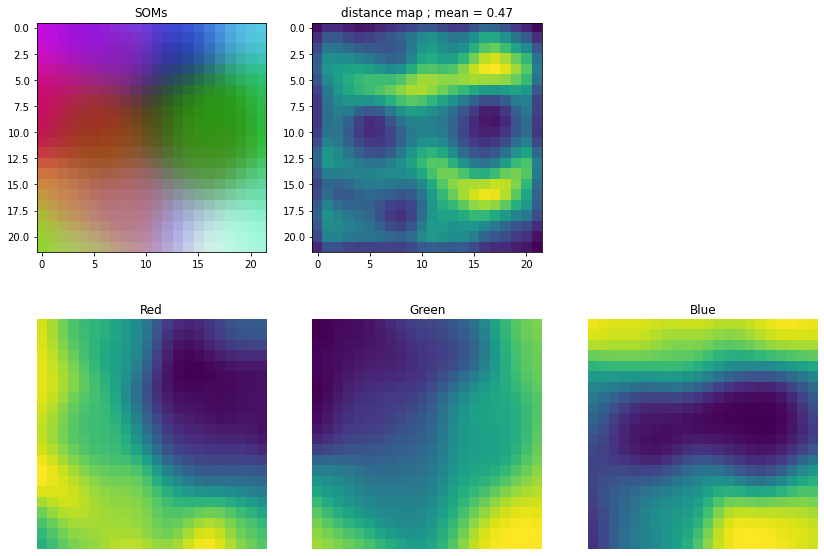

In [67]:
som, wts_color = train_som(x, y, input_len, sigma, learning_rate)

som_color(data_color, wts_color, color_names)# sigma = 4.477, learning_rate = 2.427

# COSMOS dataset

## Loading datas

In [0]:
from astropy.io import fits

path_CS_fits = "real_galaxy_catalog_25.2_fits.fits"

with fits.open(path_CS_fits) as hdul:
    hdr = hdul[0].header # header
    data_cs = hdul[1].data # data
    cols = hdul[1].columns # cols 
    Names = cols.names # cols names

In [276]:
hdul.info()
Names

Filename: real_galaxy_catalog_25.2_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   87798R x 14C   [J, D, D, D, 8D, 16D, 5J, D, D, D, J, J, 3D, 4D]   


['IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux']

## Making cuts... and selecting datas for the SOMs

In [250]:
def cut_hight_hlr(cat, lim): # delete hlr problems
    idx = np.where(cat['sersicfit'][:,1]>lim)[0]
    print("nb d'elements suppr", idx.shape)
    cat = np.delete(cat,idx)
    return cat

data_cs = cut_hight_hlr(data_cs, 40) # cut hight values

data_cs['sersicfit'][:,1] *= 0.03 # converting hlr

nb d'elements suppr (4041,)


In [0]:
hlr = data_cs['sersicfit'][:,1].copy()
sersic = data_cs['sersicfit'][:,2].copy()
q = data_cs['sersicfit'][:,3].copy()

hlr +=0.03 # converting hlr
sersic /= max(sersic) # normalisation de sersic pour le som

In [252]:
# hlr, sersic, q
choice_cs = np.array([hlr, sersic, q]).T
choice_cs.shape

(83757, 3)

## SOMs training and visualisation

SOMs len side : x = 38 
sigma = 9.000000 ; learning rate 2.000000 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.1467487405244244


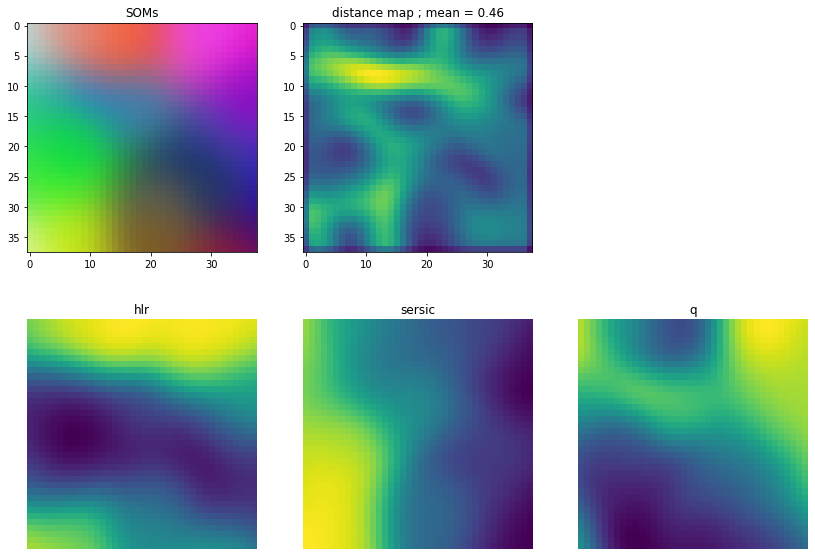

In [266]:
nb_cs = choice_cs.shape[0]

som_x = int(np.sqrt(5*np.sqrt(nb_cs)))
som_y = som_x

sigma = int(som_x/4)
learning_rate = 2

print("SOMs len side : x = %d " % som_x)
print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

som, wts_cs = train_som(data_color, 
                           som_x, som_y, 
                           data_color.shape[1], 
                           sigma=sigma, 
                           learning_rate=learning_rate,
                           iterations = 5000,
                           verbose=True)

som_color(choice_cs, som, wts_cs, ['hlr','sersic','q'])

### First result

In [221]:
som_x, som_y = [30,30] # SOMs shape

som = MiniSom(som_x, som_y, choice_cs.shape[1],
                sigma=8, learning_rate=2)

som.train(choice_cs, 10000, verbose=True)
print('topographic error :', som.topographic_error(choice_cs))

wts_cs = som.get_weights()

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.1335406928605767
topographic error : 0.01922227395919147


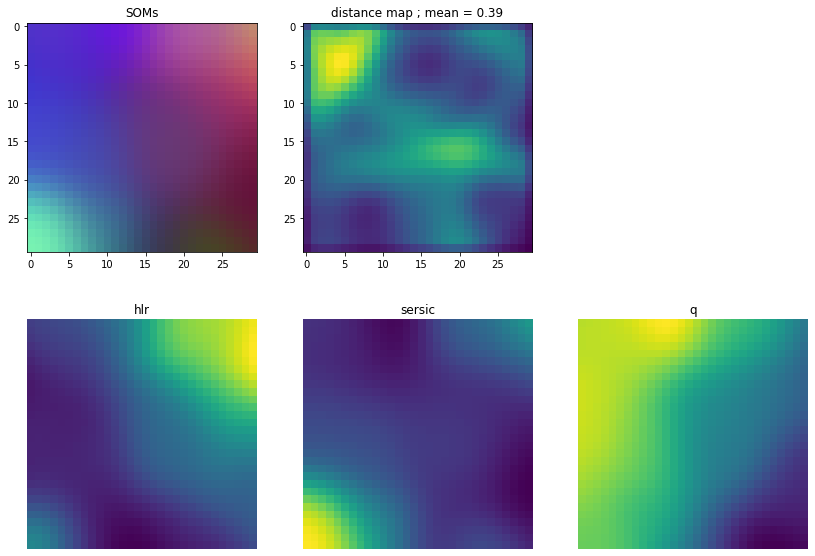

In [202]:
som_color(choice_cs, wts_cs, ['hlr','sersic','q'])

# TU dataset

In [0]:
from astropy.io import fits

path_TU = "TU_created.fits"

with fits.open(path_TU) as hdul:
    hdr = hdul[0].header # header
    data_tu = hdul[1].data # data
    cols = hdul[1].columns # cols
    Names = cols.names # cols names

In [292]:
hdul.info()

Filename: TU_created.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   314709R x 6C   [D, D, D, D, D, D]   


In [293]:
Names

['mag', 'half_light_radius', 'q', 'SSersic_n', 'PA', 'bt']

In [294]:
sersic = data_tu['SSersic_n'] / max(data_tu['SSersic_n']) # normalisation de sersic pour le som

hlr_sup1 = np.argwhere(data_tu['half_light_radius']>1) # suppression des elements de hlr > 1

hlr = np.delete(data_tu['half_light_radius'],hlr_sup1)
q = np.delete(data_tu['q'],hlr_sup1)
sersic = np.delete(sersic,hlr_sup1)

len(hlr_sup1) # nombre d'elements supprimes

338

In [295]:
# hlr, sersic, q
choice_tu = np.vstack([hlr,sersic,q]).T
choice_tu.shape

(314371, 3)

In [296]:
som_x, som_y = [30,30] # SOMs shape

som = MiniSom(som_x, som_y, choice_tu.shape[1],
                sigma=8, learning_rate=2)

som.train(choice_tu, 10000, verbose=True)
#print('quantization error :', som.quantization_error(choice_tu))
#print('topographic error :', som.topographic_error(choice_tu))

wts_tu = som.get_weights()

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.07281090106999114


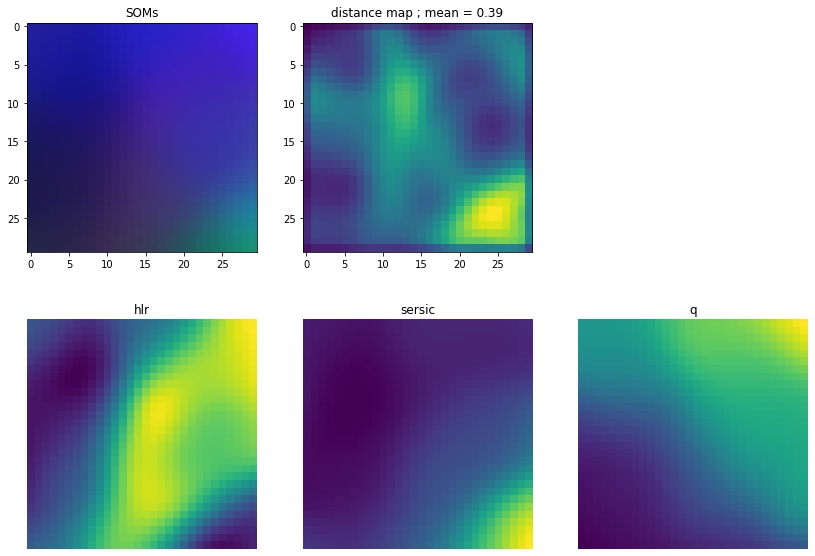

In [297]:
som_color(choice_tu, wts_tu, ['hlr','sersic','q'])